Import the relevant libraries. Surprise and its datasets are the main libraries. 

In [ ]:
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import CoClustering
from surprise import NMF
from surprise import SlopeOne
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

Load the movielens-100k dataset(csv format) from GitHub link


In [ ]:
url = 'https://raw.githubusercontent.com/MutugiD/Data-Problems/master/Recommender/movie_ratings.csv'
data = pd.read_csv(url)
data.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Create a dictionary with 3 columns, name them, and transform into a Pandas DF

In [ ]:
rating_dict = {'itemID': list(data.movieId),
                'userID': list(data.userId),
                'rating': list(data.rating)}
df = pd.DataFrame(rating_dict)
df.head()

,itemID,userID,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0


Load data from dataframe(df) created above, use load_from_df() method. Use a Reader object, and the rating_scale parameter specification

In [ ]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

Create a benchmark. Iterate over SVD, NMF, NormalPredictor, KNNBasic 

In [ ]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
benchmark = []
# Iterate over SVD, NMF, NormalPredictor, KNNBasic 
for algo in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(temp)

algo_data = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
algo_data

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.881587,4.217822,0.223484
NMF,0.935477,4.975248,0.356547
KNNBasic,0.958094,0.101014,2.234545
NormalPredictor,1.425713,0.109218,0.240784


Tune the algorithm parameters to find the optimal parameter and assign them


In [ ]:
parameters= {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
grid= GridSearchCV(SVD, parameters, measures=['rmse', 'mae'], cv=3)
trainset, testset = train_test_split(data, test_size=0.2)
grid.fit(data)
algo_best = grid.best_estimator['rmse']
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

#assign the best parameters
t_num = grid.best_params
factors = t_num['rmse']['n_factors']
epochs = t_num['rmse']['n_epochs']
lr_value = t_num['rmse']['lr_all']
reg_value = t_num['rmse']['reg_all']

0.8670067105309122
{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}



Tunining algorithmic parameters to find the best fits by use of grid search

In [ ]:
parameters= {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
grid= GridSearchCV(SVD, parameters, measures=['rmse', 'mae'], cv=3)
trainset, testset = train_test_split(data, test_size=0.2)
grid.fit(data)
algo_best = grid.best_estimator['rmse']
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

t_num = grid.best_params
factors = t_num['rmse']['n_factors']
epochs = t_num['rmse']['n_epochs']
lr_value = t_num['rmse']['lr_all']
reg_value = t_num['rmse']['reg_all']


0.9273949991891661
{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


For training and testing, train_test_split() is used, and then fitted onto the train and test sample. 

In [ ]:
trainset, testset = train_test_split(data, test_size=0.20)
algo_algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo_algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8678


0.8678207074088683

**Checking how good or bad the predictions** 

The following parameters are used: 

*   UID: user-id
*   iid: item id
*   Rui: the rating given by the user
*   est: rating estimated by the model
*   Iu: No of items rated by the user
*   UI: number of users that have rated this item
*   err: abs difference between predicted rating and the actual rating.


In [ ]:
#Gets the user_id, returns no of items rated by user
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
#Gets raw id of an item, returns no of users who have rated the item
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]


In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
16351,30,318,5.0,5.000000,{'was_impossible': False},27,248,0.000000
19866,53,1256,5.0,5.000000,{'was_impossible': False},15,16,0.000000
5371,171,1104,5.0,5.000000,{'was_impossible': False},65,16,0.000000
2314,53,1125,5.0,5.000000,{'was_impossible': False},15,18,0.000000
14533,276,260,5.0,5.000000,{'was_impossible': False},32,196,0.000000
16491,122,318,5.0,5.000000,{'was_impossible': False},231,248,0.000000
16629,523,58559,5.0,5.000000,{'was_impossible': False},56,115,0.000000
4111,452,1198,5.0,5.000000,{'was_impossible': False},155,158,0.000000
15482,33,308,4.0,4.000015,{'was_impossible': False},124,15,0.000015
19712,387,2759,3.5,3.499950,{'was_impossible': False},815,5,0.000050


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7498,154,86644,0.5,4.139330,{'was_impossible': False},25,8,3.639330
9431,594,4902,0.5,4.164414,{'was_impossible': False},188,6,3.664414
12599,580,2186,0.5,4.196262,{'was_impossible': False},340,22,3.696262
5232,393,27611,0.5,4.240243,{'was_impossible': False},100,13,3.740243
18221,105,4027,0.5,4.322540,{'was_impossible': False},569,77,3.822540
2920,557,2700,0.5,4.326548,{'was_impossible': False},20,57,3.826548
606,256,5618,0.5,4.573416,{'was_impossible': False},135,70,4.073416
2891,210,296,0.5,4.600879,{'was_impossible': False},108,259,4.100879
11443,594,2488,0.5,4.658570,{'was_impossible': False},188,2,4.158570
12241,594,7982,0.5,4.714158,{'was_impossible': False},188,3,4.214158


**Recommendations (Priotiy K items)**


In deciding Relevant and Recommended: 

Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Thus, the f1 score is: 

f1 score = 2 (precision recall) / (precision + recall)

Thus, calculation of TP,FP,TN,FN at every threshold level (0.0 - 5.0) with steps of 0.5



In [ ]:
final_result = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final_result.append(temp)

result = pd.DataFrame(final_result)
result.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
result

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,20168,0,0,0,1.000000,1.000000,1.000000
1,0.5,20168,0,0,0,1.000000,1.000000,1.000000
2,1.0,19892,276,0,0,0.986315,1.000000,0.993110
3,1.5,19337,812,8,11,0.959700,0.999431,0.979163
4,2.0,18912,1092,86,78,0.945411,0.995893,0.969995
5,2.5,17063,2177,529,399,0.886850,0.977150,0.929813
6,3.0,14536,1932,1883,1817,0.882682,0.888889,0.885774
7,3.5,8578,2162,5642,3786,0.798696,0.693788,0.742555
8,4.0,3299,672,9748,6449,0.830773,0.338428,0.480939
9,4.5,352,138,15651,4027,0.718367,0.080384,0.144588


 Function to compute precision and recall at K.

In [ ]:
#Return precision and recall at k metrics for each user
def precision_recall_at_k(predictions, k, threshold):
    

    #Map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        #User rating sorting by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        #Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls
    

result=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    #Precision and recall averaged over users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    result.append({'K': i, 'Precision': prec, 'Recall': rec})

result

[{'K': 2, 'Precision': 0.9467213114754098, 'Recall': 0.21641746118049762},
 {'K': 3, 'Precision': 0.9428961748633881, 'Recall': 0.3082933010233402},
 {'K': 4, 'Precision': 0.9405737704918031, 'Recall': 0.3841293462801094},
 {'K': 5, 'Precision': 0.9337704918032793, 'Recall': 0.4460570640644501},
 {'K': 6, 'Precision': 0.9308743169398894, 'Recall': 0.5005782882337962},
 {'K': 7, 'Precision': 0.9281030444964852, 'Recall': 0.5457033063036879},
 {'K': 8, 'Precision': 0.9264051522248237, 'Recall': 0.5822828740645563},
 {'K': 9, 'Precision': 0.9246747332812917, 'Recall': 0.6127037595161373},
 {'K': 10, 'Precision': 0.9238550611501419, 'Recall': 0.6382315595734946}]

Plot the movement of precision in K recommendations

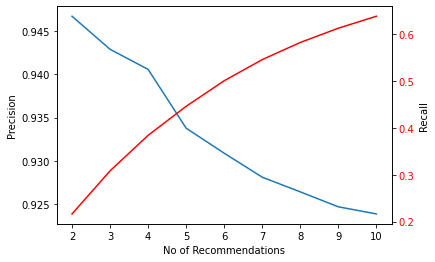

In [ ]:
Recomended=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Recomended.append(result[i]['K'])
    Precision.append(result[i]['Precision'])
    Recall.append(result[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Recomended, Precision)
plt.xlabel('No of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Recomended, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
  

Make recommendations to friends and family

In [ ]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

#predict ratings for pairs (u, i) NOT in training set
testset = trainset.build_anti_testset()

#predicting the ratings for testset
predictions = algo.test(testset)

Sort all predictions

In [ ]:
# Using K=5 for recommendations 
n = 5
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]
    
temp = pd.DataFrame.from_dict(all_pred)
temp_transpose = temp.transpose()

all_pred = get_all_predictions(predictions)


A dataframe of top K (=5) movies recommended to every user.

In [ ]:
def get_predictions(user_id):
    results = temp_transpose.loc[user_id]
    return results

#test a random user_id
user_id=120
results = get_predictions(user_id)
results

0    (177593, 4.4565436365216975)
1       (951, 4.3880349312786775)
2      (1104, 4.3776598373955355)
3        (318, 4.356221937209631)
4       (1178, 4.328357949815905)
Name: 120, dtype: object

Extract the movie_id from the result of test user_ID =120

In [ ]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])
recommended_movie_ids


[177593, 951, 1104, 318, 1178]

Load the movie information of 100k dataset from GitHub link. 

In [ ]:
movie_url = 'https://raw.githubusercontent.com/MutugiD/Data-Problems/master/Recommender/movie_info.csv'
movie = pd.read_csv(movie_url, encoding = 'ISO-8859-1')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Use the movie information to  find out the names+ addition details of the recommended movies.

In [ ]:
recommended_movies = movie[movie['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
731,951,His Girl Friday (1940),Comedy|Romance
841,1104,"Streetcar Named Desire, A (1951)",Drama
883,1178,Paths of Glory (1957),Drama|War
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
